# DSTC11 TRACK 2- Data augmentation experiment

## Setup workspace

1. Clone the 'dstc11-track2-intent-induction' repo for the first time

In [1]:
repo_name = 'dstc11-track2-intent-induction-data-augmentation'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/mikolajkrzyminski/dstc11-track2-intent-induction-data-augmentation.git

Cloning into 'dstc11-track2-intent-induction-data-augmentation'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 345 (delta 151), reused 323 (delta 132), pack-reused 0
Receiving objects: 100% (345/345), 9.28 MiB | 6.84 MiB/s, done.
Resolving deltas: 100% (151/151), done.


or import saved work from drive

In [4]:
from google.colab import drive
from google.colab import files
import zipfile

with zipfile.ZipFile(f"/content/drive/MyDrive/YRRSDS/{repo_name}.zip", 'r') as zip_ref:
    zip_ref.extractall(f"/content/{repo_name}")


Optional*: save your progress to Drive

In [ ]:
import shutil

shutil.make_archive(f'/content/drive/MyDrive/YRRSDS/{repo_name}', format='zip', root_dir=f'/content/{repo_name}')

2. Go to:

In [5]:
%cd /content/dstc11-track2-intent-induction-data-augmentation

/content/dstc11-track2-intent-induction-data-augmentation


4. Install requirements

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
!pip install --upgrade urllib3

In [11]:
import logging
import pytz
from datetime import datetime
import pprint

def logg_message(message):
    zagreb_tz = pytz.timezone('Europe/Zagreb')
    now = datetime.now(tz=pytz.utc)
    zagreb_time = now.astimezone(zagreb_tz)
    print(f"[{zagreb_time.strftime('%H:%M:%S %d-%b-%y')}]", message)

def logg_pp_message(message, pprint_message):
    logg_message(message)
    pp = pprint.PrettyPrinter(indent=4, width=40)
    pp.pprint(pprint_message)


In [12]:
logg_pp_message('hello', {'Hello': 'YRRSDS!', 'Author': 'Mikołaj Krzymiński'})

[15:10:13 26-Aug-23] hello
{   'Author': 'Mikołaj Krzymiński',
    'Hello': 'YRRSDS!'}


## Experiment

1. Setup configuration

|variable       |description |
|---------------|---|
|*size_samples* |the size of tested augmentations 0.25 means that the augmentation has a size of 25% of the base set |
|*reducted_size*|the reduction of source dataset|
|*seed*         |seed form experiment|
|*datasets*     |tested datasets remember to change datasets in dstc config files: <br/> */dstc11-track2-intent-induction-data-augmentation/configs/run-intent-clustering-baselines.jsonnet* and <br/> */dstc11-track2-intent-induction-data-augmentation/configs/run-open-intent-induction-baselines.jsonnet*|
|*tasks_names*         |tasks available for DTSC Track 2|
|*choosen_task*         |choosen task|

|const          |description           |
|---------------|----------------------|
|*project_path* |path to project       |
|*data_path*    |path for source data  |
|*red_data_path*|path for reducted data|


In [6]:
size_samples = [
    0.0,
    0.05,
    0.10,
    0.20,
    0.30,
    0.40,
    0.50,
    # 0.60,
    # 0.70,
    # 0.80,
    # 0.90,
    # 1.00
]
reducted_size = 0.1
seed          = 42
datasets      = [
    # 'development',
    # 'test-banking',
    'test-finance'
]
tasks_names = [
    "intent-clustering-baselines",
    "open-intent-induction-baselines"
]

choosen_task = tasks_names[0]

project_path  = f'/content/{repo_name}'
data_path     = f'{project_path}/dstc11'
red_data_path = f'{project_path}/mod_data/dstc11-{reducted_size}-seed{seed}'

2. Reduce dataset size

In [ ]:
import shutil
import os
import random

def get_reducted_dataset(reducted_size = reducted_size, seed = seed, data_path = data_path, red_data_path = red_data_path, datasets = datasets):
    if os.path.exists(red_data_path) and os.path.isdir(red_data_path):
        shutil.rmtree(red_data_path)
        logg_message(f'Remove existing: {red_data_path}')
    shutil.copytree(data_path, red_data_path)
    logg_message(f'Copy from: {data_path} to: {red_data_path}')
    random.seed(seed)
    for dataset_name in datasets:
        lines = []
        with open(f'{data_path}/{dataset_name}/dialogues.jsonl') as file:
            lines = [line.rstrip() for line in file]
        reducted_size_lines = round(reducted_size * len(lines))
        picked_lines_ids = random.sample(range(len(lines)), reducted_size_lines)
        sorted_lines_ids = sorted(picked_lines_ids)
        res_lines = [lines[i] for i in sorted_lines_ids]
        red_data_path = os.path.join(red_data_path, dataset_name, 'dialogues.jsonl')
        with open(red_data_path, 'w') as fp:
            for item in res_lines:
                # write each item on a new line
                fp.write("%s\n" % item)
            logg_message(f'Create: {red_data_path}')

get_reducted_dataset()

[12:41:30 26-Aug-23] Copy from: /content/dstc11-track2-intent-induction-data-augmentation/dstc11 to: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42
[12:41:30 26-Aug-23] Create: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42/development/dialogues.jsonl


3. Get customer utterances

In [ ]:
import json
import random

def get_input_text(datasets=datasets):
    input_texts = {}
    for dataset_name in datasets:
        lines = []
        dataset_input_texts = []
        red_data_customer = f'{red_data_path}/{dataset_name}/dialogues.jsonl'
        with open(red_data_customer) as file:
            lines = [line.rstrip() for line in file]
            for line in lines:
                dialogue = json.loads(line)
                # print(dialogue)
                for turn_dict in dialogue['turns']:
                    if (turn_dict['speaker_role'] == 'Customer' and 'InformIntent' in turn_dict['dialogue_acts']):
                        dataset_input_texts.append({'utterance': turn_dict['utterance'], 'intents': turn_dict['intents']})
        logg_message(f'Reading {len(dataset_input_texts)} customer utterances from: {red_data_customer}')
        logg_pp_message('Sample utterance object: ', '[..., ' + str(random.choice(dataset_input_texts)) + ',...]')

        input_texts[dataset_name] = dataset_input_texts
    return(input_texts)

input_texts = get_input_text()


[13:16:16 26-Aug-23] Reading 395 customer utterances from: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42/development/dialogues.jsonl
[13:16:16 26-Aug-23] Sample utterance object: 
('[..., {\'utterance\': "Hi Amy, Macy '
 'Nolan calling. I am not sure what I '
 'need to do but my bank, they said '
 'they need me to prove that I have '
 'insurance and the papers I have '
 'aren\'t good enough.", \'intents\': '
 "['RequestProofOfInsurance']},...]")


4. Generate augmentations, recomended to use GPU

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import copy
import tqdm
import random

def get_augmentations(dataset_input_texts=input_texts, datasets=datasets, red_data_path=red_data_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # source & destination languages
    src = "en"
    dst = "de"

    model_name1 = f"Helsinki-NLP/opus-mt-{src}-{dst}"
    model_name2 = f"Helsinki-NLP/opus-mt-{dst}-{src}"

    tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
    tokenizer2 = AutoTokenizer.from_pretrained(model_name2)

    model1 = AutoModelForSeq2SeqLM.from_pretrained(model_name1).to(device)
    model2 = AutoModelForSeq2SeqLM.from_pretrained(model_name2).to(device)

    # Translate from src to dst (e.g., en to de)
    dataset_result_translations = {}
    for dataset_name in datasets:
        aug_path = f'{red_data_path}/{dataset_name}/augmentation.json'
        if (os.path.exists(aug_path)):
            with open(aug_path, 'r') as openfile:
                dataset_result_translations[dataset_name] = json.load(openfile)
            logg_message(f'Reading existing: {aug_path}')
        else:
            augmentation_results = []
            # translated_texts1 = []
            for input_text in tqdm.tqdm(dataset_input_texts[dataset_name]):
                inputs1 = tokenizer1(input_text["utterance"], return_tensors="pt", padding=True).to(device)
                translations1 = model1.generate(**inputs1, num_return_sequences=4)
                translated_text1 = tokenizer1.decode(translations1[-1], skip_special_tokens=True)
                # translated_texts1.append(translated_text1)

            # Translate from dst to src (e.g., de to en)
            # translated_texts2 = []
            # for translated_text1 in translated_texts1:
                inputs2 = tokenizer2(translated_text1, return_tensors="pt", padding=True).to(device)
                translation2 = model2.generate(**inputs2, num_return_sequences=4)
                translated_text2 = tokenizer2.decode(translation2[-1], skip_special_tokens=True)
                # translated_texts2.append(translated_text2)
                input_text['translations'] = [input_text["utterance"], translated_text1, translated_text2]
                input_text['aug_utterance'] = translated_text2
                augmentation_results.append(input_text)
            dataset_result_translations[dataset_name] = augmentation_results
            with open(aug_path, 'w') as file:
                json.dump(augmentation_results, file)
            logg_message(f'Create: {red_data_path}/{dataset_name}/augmentation.json')
        logg_pp_message('Sample augmentation object: ', '[..., ' + str(random.choice(dataset_result_translations[dataset_name])) + ',...]')

    return(dataset_result_translations)

backtranslated_texts = get_augmentations(input_texts)

[13:16:39 26-Aug-23] Reading existing: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42/development/augmentation.json
[13:16:39 26-Aug-23] Sample augmentation object: 
("[..., {'utterance': 'Can i get that "
 'sent to my mail or can I get the '
 'information on your website. It will '
 'afford me enough time to read '
 'understand it well. You know what '
 "the say about old age ?', 'intents': "
 "[], 'translations': ['Can i get that "
 'sent to my mail or can I get the '
 'information on your website. It will '
 'afford me enough time to read '
 'understand it well. You know what '
 "the say about old age ?', 'Kann ich "
 'das an meine E-Mail geschickt '
 'bekommen oder kann ich die '
 'Informationen auf Ihrer Website. Es '
 'wird mir genügend Zeit, um es gut zu '
 "lesen.', 'Can I get that sent to my "
 'email or can I get the information '
 'on your website. It will give me '
 "enough time to read it well.'], "
 "'aug_utterance': 'Can I get that "

5. Sampling augmentations

In [ ]:
import random
from collections import Counter
import numpy
import copy

def choose_random_elements_indices(data_dict, size, datasets=datasets, seed=seed):
    random.seed(seed)
    results_datasets = {}
    for dataset_name in datasets:
        data = data_dict[dataset_name]
        num_samples = round(len(data) * size)
        sample_indices = random.sample(range(len(data)), num_samples)
        results_datasets[dataset_name] = sample_indices
    return results_datasets

#def choose_random_elements_with_non_empty_intent(data_dict, size, datasets=datasets, seed=seed):
#    random.seed(seed)
#    results_datasets = {}
#    for dataset_name in datasets:
#        data = data_dict[dataset_name]
#        non_empty_intent_data = [item for item in data if item['intents']]
#        num_samples = round(len(non_empty_intent_data) * size)
#        results_datasets[dataset_name] = random.sample(non_empty_intent_data, num_samples)
#    return results_datasets
#
#def sample_data_with_rarity(data_dict, sample_percentage, datasets=datasets, seed=seed):
#    numpy.random.seed(seed)
#    results_datasets = {}
#    for dataset_name in datasets:
#        data = data_dict[dataset_name]
#        # Count the occurrences of each intent
#        intent_counter = Counter()
#
#        for item in data:
#            if not item['intents']:
#                intent_counter['<unk>'] += 1
#            else:
#                intent_counter.update(item['intents'])
#        # intent_counter = Counter(intent for item in data for intent in item['intents'] if item['intents'])
#        # print(intent_counter)
#        intents_num = sum(intent_counter.values())
#        intent_rarity = {intent: count / intents_num for intent, count in intent_counter.items()}
#        num_samples = round(len(data) * sample_percentage)
#        # print(num_samples)
#        # print(intent_rarity)
#        weights = {element : 1 / intent_rarity[element] for element in intent_rarity}
#
#        # Normalize the weights to sum up to 1
#        total_weight = sum(weights.values())
#        normalized_weights = {weight: weights[weight] / (total_weight * intent_counter[weight]) for weight in weights}
#        # print(normalized_weights)
#        # Calculate the number of samples based on the sample percentage
#        p = [sum(normalized_weights[item] for item in entry["intents"]) if entry["intents"] else normalized_weights['<unk>'] for entry in data]
#        results_datasets[dataset_name] = numpy.random.choice(data, size=num_samples, replace=False, p=p)
#
#    return results_datasets

dialogue_template = {
    "dialogue_id": "",
    "turns": []
    }

turn_template_customer = {
    "turn_id"      : "",
    "speaker_role" : "Customer",
    "utterance"    : "",
    "dialogue_acts": ["InformIntent"],
    "intents"      : []
    }

turn_template_agent = {
    "turn_id"      : "",
    "speaker_role" : "Agent",
    "utterance"    : "",
    "dialogue_acts": [],
    "intents"      : []
    }

def add_augmentation_jsonl(datasets_augmentations, size_sample, datasets=datasets, red_data_path=red_data_path):
    aug_red_data_path = f'{red_data_path}-aug{size_sample}'
    if not os.path.exists(aug_red_data_path) and not os.path.isdir(aug_red_data_path):
        os.mkdir(aug_red_data_path)
        logg_message(f"Creating: {aug_red_data_path}")
    else:
        logg_message(f"Directory already exists: {aug_red_data_path}")


    for dataset_name in datasets:
        dialogue_id = ""
        turn_id_name = ""
        dialogues_path = f'{red_data_path}/{dataset_name}/dialogues.jsonl'
        with open(dialogues_path) as file:
            lines = [line.rstrip() for line in file]
            json_last_line = json.loads(lines[-1])
            if 'development' == dataset_name:
                dialogue_id = '{:0>3}'.format(int(json_last_line['dialogue_id']) + 1)
            else:
                dialogue_id = '{:0>3}'.format(int(json_last_line['dialogue_id'].split('_')[1]) + 1)
            turn_id_name = json_last_line['turns'][0]['turn_id'].split('_')[0]
        artificial_dialogue = ""
        dialogue_temp = copy.deepcopy(dialogue_template)
        dialogue_temp['dialogue_id'] = dialogue_id
        for i, augmentation in enumerate(datasets_augmentations[dataset_name]):
            turn_temp_agent = copy.deepcopy(turn_template_agent)
            turn_temp_agent['turn_id'] = f"{turn_id_name}_{dialogue_id}_" + "{:0>3}".format(2 * i)
            dialogue_temp['turns'].append(turn_temp_agent)
            turn_temp_customer = copy.deepcopy(turn_template_customer)
            turn_temp_customer['turn_id'] = f"{turn_id_name}_{dialogue_id}_" + "{:0>3}".format((2 * i) + 1)
            turn_temp_customer['utterance'] = augmentation['aug_utterance']
            turn_temp_customer['intents'] = augmentation['intents']

            dialogue_temp['turns'].append(turn_temp_customer)

        dataset_name_dir = f'{aug_red_data_path}/{dataset_name}'
        dialogues_augmentation_path = f'{dataset_name_dir}/dialogues_augmentation.jsonl'
        if not os.path.exists(dataset_name_dir) and not os.path.isdir(dataset_name_dir):
            os.mkdir(dataset_name_dir)
            logg_message(f"Create: {dataset_name_dir}")
        with open(dialogues_augmentation_path, 'w+') as file:
            file.write(json.dumps(dialogue_temp) +  "\n")
            logg_message(f"Add dialogues to: {dialogues_augmentation_path} \n")

def get_elements_by_indices(elements, indices, datasets=datasets):
    results_sorted_elements = {}
    for dataset in datasets:
        results_sorted_elements[dataset] = [elements[dataset][i] for i in sorted(indices[dataset])]
    return results_sorted_elements

for size_sample in size_samples:
    pure_random_elements_indices = choose_random_elements_indices(backtranslated_texts, size_sample)
    element_by_indicies = get_elements_by_indices(elements=backtranslated_texts, indices=pure_random_elements_indices)
    add_augmentation_jsonl(datasets_augmentations = element_by_indicies, size_sample=size_sample)

# for size_sample in size_samples:
#     pure_random_elements = choose_random_elements_indices(backtranslated_texts, size_sample)
#     # random_elements_with_non_empty_intent = choose_random_elements_with_non_empty_intent(backtranslated_texts, size_sample)
#     # weighted_random_elements = sample_data_with_rarity(backtranslated_texts, size_sample)
#     add_augmentation_to_data(datasets_augmentations = pure_random_elements, size_sample=size_sample)

[13:24:25 26-Aug-23] Directory already exists: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42-aug0.0
[13:24:25 26-Aug-23] Add dialogues to: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42-aug0.0/development/dialogues_augmentation.jsonl 

[13:24:25 26-Aug-23] Directory already exists: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42-aug0.05
[13:24:25 26-Aug-23] Add dialogues to: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42-aug0.05/development/dialogues_augmentation.jsonl 

[13:24:25 26-Aug-23] Directory already exists: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42-aug0.1
[13:24:25 26-Aug-23] Add dialogues to: /content/dstc11-track2-intent-induction-data-augmentation/mod_data/dstc11-0.1-seed42-aug0.1/development/dialogues_augmentation.jsonl 

[13:24:25 26-Aug-23] Directory already exists: /content/dst

In [ ]:
import subprocess
import sys

def get_shell_command(data_size, aug_size, dataset, task_name):
    result_script = f"""
        sed -i 's/\\r$//' {project_path}/run_colab_experiment.sh;
        bash {project_path}/run_colab_experiment.sh {data_size} {aug_size} {dataset} {task_name}
    """
    return result_script

for size_sample in size_samples:
    for dataset in datasets:
        shell_command = get_shell_command(data_size=reducted_size, aug_size=size_sample, dataset=dataset, task_name=choosen_task)

        process = subprocess.Popen(shell_command, shell=True, executable="/bin/bash", stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, bufsize=1)

        logg_message(f"Running command for data size={reducted_size}, size sample={size_sample}, dataset={dataset}, task={choosen_task}")

        for line in process.stdout:
            print(line, end='')
            sys.stdout.flush()

        for line in process.stderr:
            print(line, end='')
            sys.stderr.flush()

        process.wait()

        logg_message(f"Command completed for size_sample={size_sample}, dataset={dataset}")


[14:28:06 26-Aug-23] Running command for data size=0.1, size sample=0.0, dataset=development, task=intent-clustering-baselines

 38%|███▊      | 38/100 [00:17<00:28,  2.21trial/s, best loss: -0.07816305756568909]

 34%|███▍      | 34/100 [00:23<00:44,  1.47trial/s, best loss: -0.13409215211868286]
2023-08-26 12:28:08.524759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
2023-08-26 12:28:12,986 - type = meta_experiment
2023-08-26 12:28:13,566 - run_id = intent-clustering-baselines
2023-08-26 12:28:13,567 - experiments.0.type = intent_clustering_experiment
20

In [ ]:
data_root_dir="dstc11-0.05-seed42-aug0.0"
!rm -rf {data_root_dir}/results
!python3 -m sitod.run_experiment \
--data_root_dir {data_root_dir} \
--experiment_root_dir results \
--config configs/run-open-intent-induction-baselines.jsonnet
!mv results {data_root_dir}/results
!rm -rf cache
!rm -rf results

## Create plots

In [7]:
import pandas as pd
import copy
import os

results_df = pd.DataFrame()


for size_sample in size_samples:
    aug_red_data_path = f'{red_data_path}-aug{size_sample}'
    temp_df = pd.read_table(os.path.join(aug_red_data_path, f'results/{choosen_task}/summary.tsv'))

    temp_df['size_sample'] = size_sample

    if results_df.empty:
        results_df = copy.deepcopy(temp_df)
    else:
        results_df = pd.concat([results_df, temp_df], axis=0, ignore_index=True)



In [8]:
results_df

,RunID,NMI,ARI,ACC,Precision,Recall,F1,Example Coverage,Reference K,K,size_sample
0,kmeans_all-mpnet-base-v2,74.1343,34.3778,49.0566,72.6415,49.0566,58.5637,93.3962,22.0,38.0,0.00
1,kmeans_glove-840b-300d,66.1533,12.1309,37.7358,66.9811,40.5660,50.5296,96.2264,22.0,47.0,0.00
2,kmeans_all-mpnet-base-v2,75.8212,31.8402,47.3214,78.5714,48.2143,59.7586,95.5357,22.0,42.0,0.05
3,kmeans_glove-840b-300d,65.0338,10.8898,35.7143,65.1786,39.2857,49.0232,96.4286,22.0,47.0,0.05
4,kmeans_all-mpnet-base-v2,75.9959,35.1552,45.6140,78.9474,47.3684,59.2105,94.7368,22.0,50.0,0.10
5,kmeans_glove-840b-300d,62.6997,15.0513,38.5965,60.5263,42.9825,50.2676,92.1053,22.0,39.0,0.10
6,kmeans_all-mpnet-base-v2,74.8452,26.9325,44.0000,80.8000,45.6000,58.2987,96.8000,22.0,47.0,0.20
7,kmeans_glove-840b-300d,64.9958,13.9951,36.0000,66.4000,39.2000,49.2970,95.2000,22.0,48.0,0.20
8,kmeans_all-mpnet-base-v2,73.4132,23.6016,41.2214,78.6260,43.5115,56.0210,95.4198,22.0,50.0,0.30
9,kmeans_glove-840b-300d,65.5279,15.0872,36.6412,66.4122,40.4580,50.2835,92.3664,22.0,48.0,0.30


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

<ipython-input-13-1cecf95145ff>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Blues')(float(metric_shade))
<ipython-input-13-1cecf95145ff>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Oranges')(float(metric_shade))


<Figure size 1000x600 with 0 Axes>

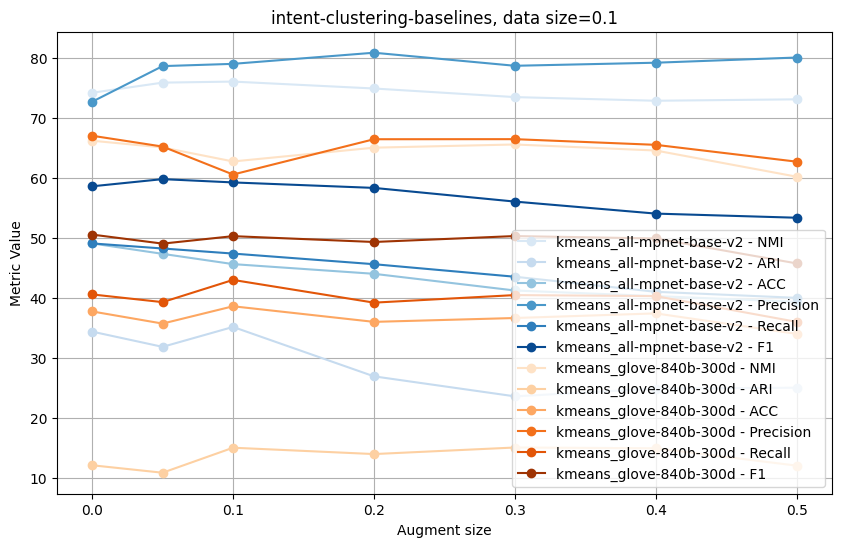

<ipython-input-13-1cecf95145ff>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Blues')(float(metric_shade))
<ipython-input-13-1cecf95145ff>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('Oranges')(float(metric_shade))


<Figure size 640x480 with 0 Axes>

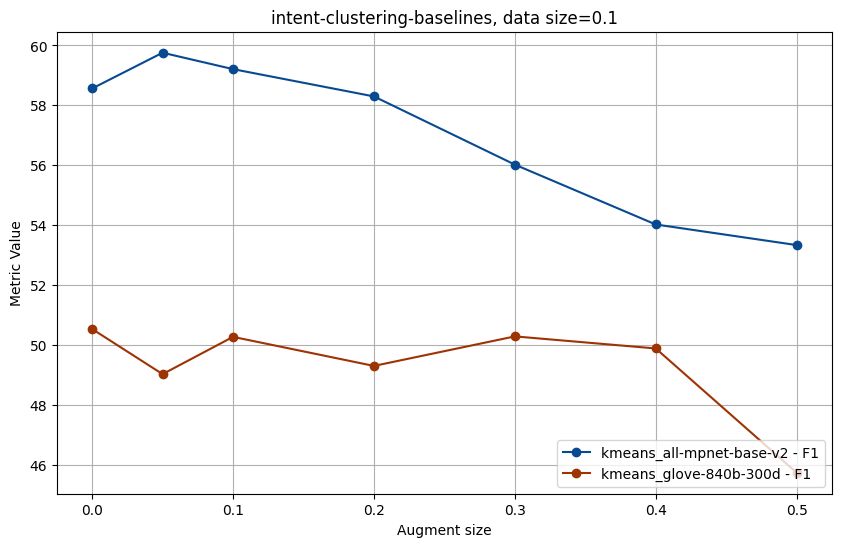

In [13]:
def plot_metrics_with_utterances(df):
    plt.figure(figsize=(10, 6))

    metric_checkboxes = {metric: widgets.Checkbox(description=metric, value=True) for metric in df.columns[1:7]}
    metric_checkbox_group = widgets.VBox(list(metric_checkboxes.values()))

    redraw_button = widgets.Button(description='Redraw Plot')

    run_id_dropdown = widgets.SelectMultiple(options=df['RunID'].unique(), description='RunID:', value=['kmeans_all-mpnet-base-v2', 'kmeans_glove-840b-300d'])

    def update_plot(_):
        plt.clf()
        plt.figure(figsize=(10, 6))

        metric_colors = {
            'NMI': '0.15', 'ARI': '0.25', 'ACC': '0.40',
            'Precision': '0.60', 'Recall': '0.70', 'F1': '0.9'
        }

        for run_id in run_id_dropdown.value:
            run_df = df[df['RunID'] == run_id]
            if run_id == 'kmeans_all-mpnet-base-v2':
                color = 'blue'
            else:
                color = 'orange'

            for metric, checkbox in metric_checkboxes.items():
                if checkbox.value:
                    metric_shade = metric_colors[metric]
                    if run_id == 'kmeans_glove-840b-300d':
                        color = plt.cm.get_cmap('Oranges')(float(metric_shade))
                    elif run_id == 'kmeans_all-mpnet-base-v2':
                        color = plt.cm.get_cmap('Blues')(float(metric_shade))
                    plt.plot(run_df['size_sample'], run_df[metric], marker='o', label=f'{run_id} - {metric}', color=color)

        plt.xlabel('Augment size')
        plt.ylabel('Metric Value')
        plt.title(f'{choosen_task}, data size={reducted_size}')

        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    redraw_button.on_click(update_plot)

    controls = widgets.VBox([run_id_dropdown, metric_checkbox_group, redraw_button])

    display(controls)
    update_plot(None)

plot_metrics_with_utterances(results_df)
